# Dynamic cross-correlation analysis

In [6]:
import pytraj as pt
import nglview as nv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
%cd ~/workshop_pytraj/example_02

/home/user090/workshop_pytraj/example_02


In this lesson we will analyze two fragments of the simulation system:
1. Protein fragment (residues 50-150).
2. Nucleic acids.

## Visualize the whole system
Let's visualize the whole system before running correlation analysis. This will help to understand where the fragments of the system chosen for analysis are located. 

- Load 20 equispaced frames from the 2 ns - long trajectory for visualization   
- Move atoms back into the initial box
- Center the view using alpha carbon atoms of the protein. 

In [22]:
trj_viz=pt.iterload('mdcrd_nowat.xtc', top='prmtop_nowat.parm7', frame_slice=[(0,1999,100)])
trj_viz=trj_viz.autoimage()
trj_viz.center('@CA origin')

pytraj.TrajectoryIterator, 20 frames: 
Size: 0.006859 (GB)
<Topology: 15344 atoms, 1285 residues, 390 mols, PBC with box type = orthorhombic>
           

- Create view of the loaded data
- Set orthographic projection
- Remove the default ball/stick representation 
- Add nucleic acids represented with tube
- Add protein surface
- Add protein residues 50-150 represented with cartoon

In [24]:
view1 = trj_viz.visualize()
view1.camera='orthographic'
view1.clear()
view1.add_tube('nucleic')
view1.add_hyperball('nucleic and not hydrogen', colorScheme="element")
view1.add_surface('protein', color='grey', opacity=0.3)
view1.add_cartoon('50-150', color='cyan')

- Display the view

In [25]:
view1

NGLWidget(max_frame=19)

## 1. Analyze dynamic cross-correlation map for the protein atoms.  
We will use residues 50-100, these residues represent a fragment of the protein molecule.
- Load all trajectory frames for analysis 

In [26]:
traj=pt.iterload('mdcrd_nowat.xtc', top='prmtop_nowat.parm7')

- Calculate correlation matrix for residues 50-150

In [12]:
corrmat=pt.atomiccorr(traj, mask=":50-150 and not hydrogen")

- Plot correlation matrix using heat map
- Set center of the color scale to 0

<Axes: >

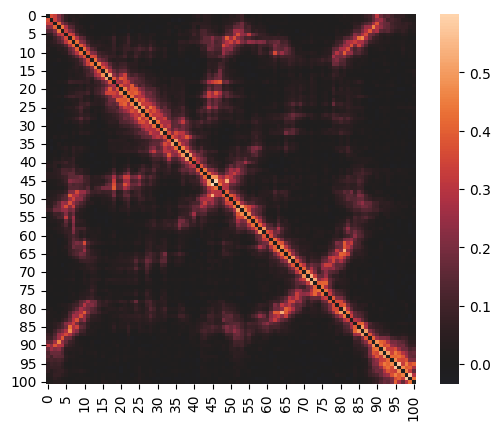

In [27]:
sns.heatmap(corrmat, center=0, xticklabels=5, yticklabels=5, square=True)

### Intrepretation of the correlation map
- Close to diagonal are interaction between neighbours
- Off-diagonal correlations are due to the specific protein folding pattern
- Are there any negative correlations? Try rescale and plot only negative correlations (use vmax=0).

## 2. Calculate dynamic cross-correlation map for the nucleic acids.
In this example we will compare cross-correlation maps computed for different time windows of the molecular dynamics trajectory, and learn how to plot positive and negative correlations in one figure.

### Visualize nucleic acids 
- Create view 
- Set orthographic projection
- Remove the default representation
- Add nucleic backbone represented with tube
- Add nucleic acids represented with hyperball to the view
- Open the interactive view

In [14]:
view = trj_viz.visualize()
view.camera='orthographic'
view.clear()
view.add_tube('nucleic')
view.add_hyperball('nucleic and not hydrogen', colorScheme="element")

In [15]:
view

NGLWidget(max_frame=19)

- To find the numbers of the first and the last nucleic acid residue hover with the mouse cursor over the terminal atoms.

### Compute correlation map for frames 1-500

In [33]:
traj1 = pt.iterload('mdcrd_nowat.xtc', top='prmtop_nowat.parm7', frame_slice=[(1, 1000)])
corrmat1=pt.atomiccorr(traj1, mask =":860-898 and not hydrogen")

### Compute correlation map for frames 1600-1999

Load the second chunk of the trajectory and compute the correlation matrix

In [34]:
traj2 = pt.iterload('mdcrd_nowat.xtc', top='prmtop_nowat.parm7', frame_slice=[(2140, 3140)])
corrmat2=pt.atomiccorr(traj2, mask =":860-898 and not hydrogen")

### Create lower and upper triangular masks

Weak negative correlations are hard to see in one figure. Using separate color maps for negative and positive correlations can help to show weaker negative correlations clearly.
To achieve this we can set the minimum value for the positive plot, and the maximum value for the negative plot to zero. 

We can then combine plots of positive and negative correlations in one plot by showing positive correlations in the upper triangle of the correlation map, and negative correlations in the lower triangle. This can be achieved by removing the lower triangle from the plot of positive correlations, and removing the upper triangle from the plot of negative correlations. To do this we need to create masks for upper and lower triangles.

In [31]:
maskl = np.tril(np.ones_like(corrmat1, dtype=bool))
masku = np.triu(np.ones_like(corrmat1, dtype=bool))

### Try different color schemes

In [20]:
#cmap=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
cmap=sns.diverging_palette(220, 20, as_cmap=True)
#cmap=sns.color_palette("coolwarm", as_cmap=True)
#cmap=sns.color_palette("Spectral", as_cmap=True).reversed()
#cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)

### Plot correlation maps for two trajectory time windows

<Axes: >

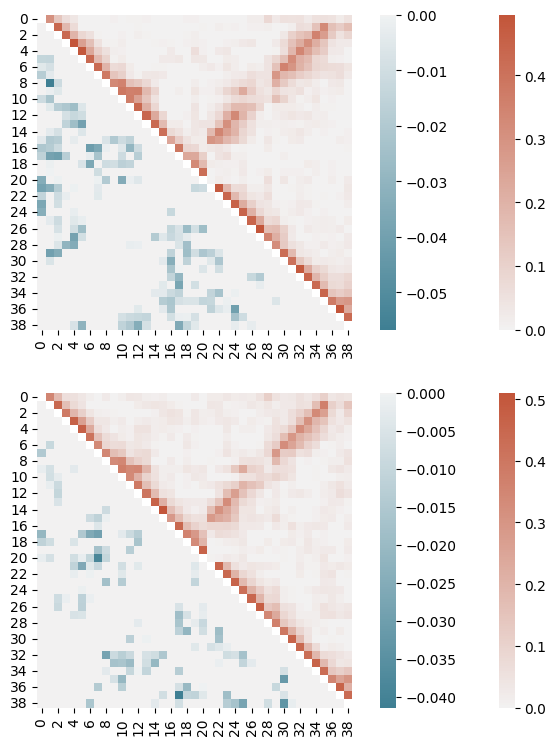

In [35]:
#  Create figure with two subplots.
fig, (ax1,ax2) = plt.subplots(2, figsize=(9,9))

# Plot correlation map for frames 1-500 (axis ax1)
# First plot positive correlations (vmin=0), then negative (vmax=0)

sns.heatmap(corrmat1, mask=maskl, cmap=cmap, center=0.0,vmin=0.0,
            square=True, xticklabels=2, yticklabels=2, ax=ax1)
sns.heatmap(corrmat1, mask=masku, cmap=cmap, center=0.0, vmax=0.0,
            square=True,ax=ax1)

# Plot correlation map for frames 1600-1999 (axis ax2)
# First plot positive correlations (vmin=0), then negative (vmax=0)

sns.heatmap(corrmat2, mask=maskl, cmap=cmap, center=0.0,vmin=0.0,
            square=True, xticklabels=2, yticklabels=2, ax=ax2)
sns.heatmap(corrmat2, mask=masku, cmap=cmap, center=0.0, vmax=0.0,
            square=True,ax=ax2)

### Interpretation of the map features 
- Correlations between neighbours do not exist between chains (21 is not correlated with 22)
- Off diagonal correlations correspond to hydrogen bonds between the two RNA chains
- Negative correlations change with time